# pyplearnr demo
Here I demonstrate pyplearnr, a wrapper for building/training/validating scikit learn pipelines using GridSearchCV or RandomizedSearchCV.

Quick keyword arguments give access to optional feature selection (e.g. SelectKBest), scaling (e.g. standard scaling), use of feature interactions, and data transformations (e.g. PCA, t-SNE) before being fed to a classifier/regressor.

After building the pipeline, data can be used to perform a nested (stratified if classification) k-folds cross-validation and output an object containing data from the process, including the best model.

Various default pipeline step parameters for the grid-search are available for quick iteration over different pipelines, with the option to ignore/override them in a flexible way.

This is an on-going project that I intend to update with more models and pre-processing options and also with corresponding defaults.

## Titanic dataset example
Here I use the Titanic dataset I've cleaned and pickled in a separate tutorial.

### Import data

In [1]:
import pandas as pd

df = pd.read_pickle('trimmed_titanic_data.pkl')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890 entries, 0 to 890
Data columns (total 9 columns):
Survived    890 non-null int64
Pclass      890 non-null int64
Sex         890 non-null object
Age         890 non-null float64
SibSp       890 non-null int64
Parch       890 non-null int64
Fare        890 non-null float64
Embarked    890 non-null object
Title       890 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 69.5+ KB


By "cleaned" I mean I've derived titles (e.g. "Mr.", "Mrs.", "Dr.", etc) from the passenger names, imputed the missing Age values using polynomial regression with grid-searched 10-fold cross-validation, filled in the 3 missing Embarked values with the mode, and removed all fields that could be considered an id for that individual.

Thus, there is no missing/null data.

## Set categorical features as type 'category'
In order to one-hot encode categorical data, its best to set the features that are considered categorical:

In [2]:
simulation_df = df.copy()

categorical_features = ['Survived','Pclass','Sex','Embarked','Title']

for feature in categorical_features:
    simulation_df[feature] = simulation_df[feature].astype('category')
    
simulation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890 entries, 0 to 890
Data columns (total 9 columns):
Survived    890 non-null category
Pclass      890 non-null category
Sex         890 non-null category
Age         890 non-null float64
SibSp       890 non-null int64
Parch       890 non-null int64
Fare        890 non-null float64
Embarked    890 non-null category
Title       890 non-null category
dtypes: category(5), float64(2), int64(2)
memory usage: 39.3 KB


## One-hot encode categorical features

In [3]:
simulation_df = pd.get_dummies(simulation_df,drop_first=True)

simulation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890 entries, 0 to 890
Data columns (total 17 columns):
Age               890 non-null float64
SibSp             890 non-null int64
Parch             890 non-null int64
Fare              890 non-null float64
Survived_1        890 non-null uint8
Pclass_2          890 non-null uint8
Pclass_3          890 non-null uint8
Sex_male          890 non-null uint8
Embarked_Q        890 non-null uint8
Embarked_S        890 non-null uint8
Title_Dr          890 non-null uint8
Title_Military    890 non-null uint8
Title_Miss        890 non-null uint8
Title_Mr          890 non-null uint8
Title_Mrs         890 non-null uint8
Title_Noble       890 non-null uint8
Title_Rev         890 non-null uint8
dtypes: float64(2), int64(2), uint8(13)
memory usage: 46.1 KB


Now we have 17 features.

### Split into input/output data

In [4]:
# Set output feature
output_feature = 'Survived_1'

# Get all column names
column_names = list(simulation_df.columns)

# Get input features
input_features = [x for x in column_names if x != output_feature]

# Split into features and responses
X = simulation_df[input_features].copy()
y = simulation_df[output_feature].copy()

### Null model

In [5]:
simulation_df['Survived_1'].value_counts().values/float(simulation_df['Survived_1'].value_counts().values.sum())

array([ 0.61573034,  0.38426966])

Thus, null accuracy of ~62% if always predict death.

### Import pyplearnr and initialize optimized pipeline collection

In [7]:
%matplotlib inline

import pyplearnr as ppl

optimized_pipelines = {}

### Basic models w/ no pre-processing
#### KNN
Here we do a K-nearest neighbors (KNN) classification with stratified 10-fold (default) cross-validation with a grid search over the default of 1 to 30 nearest neighbors and the use of either "uniform" or "distance" weights:

In [8]:
%%time

estimator = 'knn'

# Set pipeline keyword arguments
optimized_pipeline_kwargs = {
    'feature_selection_type': None,
    'scale_type': None,
    'feature_interactions': False,
    'transform_type': None
    }

# Initialize pipeline
optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)

# Set pipeline fitting parameters
fit_kwargs = {
    'cv': 10,
    'num_parameter_combos': None,
    'n_jobs': -1,
    'random_state': 6,
    'suppress_output': True,
    'use_default_param_dist': True,
    'param_dist': None,
    'test_size': 0.2 # 20% saved as test set
}

# Fit data
optimized_pipeline.fit(X,y,**fit_kwargs)

# Save 
optimized_pipelines[estimator] = optimized_pipeline

CPU times: user 1.69 s, sys: 145 ms, total: 1.83 s
Wall time: 1.94 s


The output of the train_model() method is an instance of my custom OptimizedPipeline class  containing all of the data associated with the nested stratified k-folds cross-validation.

This includes the data, its test/train splits (based on the test_size percentage keyword argument), the GridSearchCV or RandomizedGridSearchCV object, the Pipeline object that has been retrained using all of the data with the best parameters, test/train scores, and validation metrics/reports.

A report can be printed immediately after the fit by setting the suppress_output keyword argument to True. 

It lists the steps in the pipeline, their optimized settings, the test/training accuracy (or L2 regression score), the grid search parameters, and the best parameters.

If the estimator used is a classifier it also includes the confusion matrix, normalized confusion matrix, and a classification report containing precision/recall/f1-score for each class.

This same report is also accessible by printing the OptimizedPipeline class instance:

In [9]:
print optimized_pipeline


Pipeline:

1: estimator   KNeighborsClassifier           
                                              
               n_neighbors          = 12        
               n_jobs               = 1         
               algorithm            = auto      
               metric               = minkowski 
               metric_params        = None      
               p                    = 2         
               weights              = uniform   
               leaf_size            = 30        
                                              

Training set classification accuracy:	0.729
Test set classification accuracy:	0.736

Confusion matrix:

[[99  7]
 [40 32]]

Normalized confusion matrix:

[[ 0.55617978  0.03932584]
 [ 0.2247191   0.17977528]]

Classification report:

             precision    recall  f1-score   support

          0       0.71      0.93      0.81       106
          1       0.82      0.44      0.58        72

avg / total       0.76      0.74      0.71       178


Grid

Turns out that the best settings are 12 neighbors and the use of the 'uniform' weight.

Note how I've set the random_state keyword agument to 6 so that the models can be compared using the same test/train split.

The default parameters to grid-search over for k-nearest neighbors are 1 to 30 neighbors and either the 'uniform' or 'distance' weight.

The defaults for the pre-processing steps, classifiers, and regressors can be viewed by using the get_default_pipeline_step_parameters() method with the number of features as the input:

In [10]:
pre_processing_grid_parameters,classifier_grid_parameters,regression_grid_parameters = \
optimized_pipeline.get_default_pipeline_step_parameters(X.shape[0])

classifier_grid_parameters['knn']

{'n_neighbors': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30],
 'weights': ['uniform', 'distance']}

These default parameters can be ignored by setting the use_default_param_dist keyword argument to False. 

The param_dist keyword argument can be used to keep default parameters (if use_default_param_dist set to True) or to be used as the sole source of parameters (if use_default_param_dist set to False). 

Here is a demonstration of generation of default parameters with those in param_dist being overridden:

In [11]:
%%time

estimator_name = 'knn'

model_name = 'custom_override_%s'%(estimator_name)

# Set custom parameters
param_dist = {
    'estimator__n_neighbors': range(30,500)
}

# Set pipeline keyword arguments
optimized_pipeline_kwargs = {
    'feature_selection_type': None,
    'scale_type': None,
    'feature_interactions': False,
    'transform_type': None
    }

# Initialize pipeline
optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)

# Set pipeline fitting parameters
fit_kwargs = {
    'cv': 10,
    'num_parameter_combos': None,
    'n_jobs': -1,
    'random_state': 6,
    'suppress_output': False,
    'use_default_param_dist': True,
    'param_dist': param_dist,
    'test_size': 0.2 # 20% saved as test set
}

# Fit data
optimized_pipeline.fit(X,y,**fit_kwargs)

# Save 
optimized_pipelines[model_name] = optimized_pipeline


Pipeline:

1: estimator   KNeighborsClassifier           
                                              
               n_neighbors          = 50        
               n_jobs               = 1         
               algorithm            = auto      
               metric               = minkowski 
               metric_params        = None      
               p                    = 2         
               weights              = distance  
               leaf_size            = 30        
                                              

Training set classification accuracy:	0.739
Test set classification accuracy:	0.719

Confusion matrix:

[[95 11]
 [39 33]]

Normalized confusion matrix:

[[ 0.53370787  0.06179775]
 [ 0.21910112  0.18539326]]

Classification report:

             precision    recall  f1-score   support

          0       0.71      0.90      0.79       106
          1       0.75      0.46      0.57        72

avg / total       0.73      0.72      0.70       178


Grid

Note how the n_neighbors parameter was 30 to 499 instead of 1 to 30.

Here's an example of only using param_dist for parameters:

In [12]:
%%time

model_name = 'from_scratch_%s'%(estimator_name)

# Set custom parameters
param_dist = {
    'estimator__n_neighbors': range(10,30)
}

estimator = 'knn'

# Set pipeline keyword arguments
optimized_pipeline_kwargs = {
    'feature_selection_type': None,
    'scale_type': None,
    'feature_interactions': False,
    'transform_type': None
    }

# Initialize pipeline
optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)

# Set pipeline fitting parameters
fit_kwargs = {
    'cv': 10,
    'num_parameter_combos': None,
    'n_jobs': -1,
    'random_state': 6,
    'suppress_output': False,
    'use_default_param_dist': False,
    'param_dist': param_dist,
    'test_size': 0.2 # 20% saved as test set
}

# Fit data
optimized_pipeline.fit(X,y,**fit_kwargs)

# Save 
optimized_pipelines[model_name] = optimized_pipeline


Pipeline:

1: estimator   KNeighborsClassifier           
                                              
               n_neighbors          = 12        
               n_jobs               = 1         
               algorithm            = auto      
               metric               = minkowski 
               metric_params        = None      
               p                    = 2         
               weights              = uniform   
               leaf_size            = 30        
                                              

Training set classification accuracy:	0.729
Test set classification accuracy:	0.736

Confusion matrix:

[[99  7]
 [40 32]]

Normalized confusion matrix:

[[ 0.55617978  0.03932584]
 [ 0.2247191   0.17977528]]

Classification report:

             precision    recall  f1-score   support

          0       0.71      0.93      0.81       106
          1       0.82      0.44      0.58        72

avg / total       0.76      0.74      0.71       178


Grid

Note how the estimator\_\_weights parameter isn't set for the KNN estimator.

#### Other models

This code currently supports K-nearest neighbors, logistic regression, support vector machines, multilayer perceptrons, random forest, and adaboost.
We can loop through and pick the best model like this:

In [13]:
%%time

classifiers = ['knn','logistic_regression','svm',
               'multilayer_perceptron','random_forest','adaboost']

for estimator in classifiers:
    # Set pipeline keyword arguments
    optimized_pipeline_kwargs = {
        'feature_selection_type': None,
        'scale_type': None,
        'feature_interactions': False,
        'transform_type': None
        }

    # Initialize pipeline
    optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)
    
    # Set pipeline fitting parameters
    fit_kwargs = {
        'cv': 10,
        'num_parameter_combos': None,
        'n_jobs': -1,
        'random_state': 6,
        'suppress_output': True,
        'use_default_param_dist': True,
        'param_dist': None,
        'test_size': 0.2
    }
    
    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)
    
    # Save 
    optimized_pipelines[estimator] = optimized_pipeline

CPU times: user 5.79 s, sys: 541 ms, total: 6.33 s
Wall time: 37.5 s


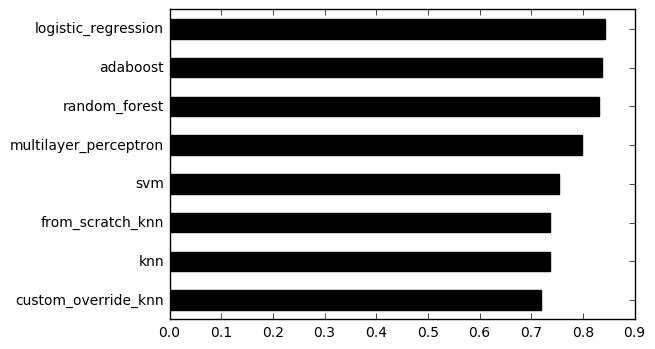

In [39]:
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black')

Logistic regression performed the best.

Lets look at the report:

In [42]:
print optimized_pipelines['logistic_regression']


Pipeline:

1: estimator   LogisticRegression             
                                              
               warm_start           = 0         
               C                    = 100000.0  
               n_jobs               = 1         
               verbose              = 0         
               intercept_scaling    = 1         
               fit_intercept        = 1         
               max_iter             = 100       
               penalty              = l2        
               multi_class          = ovr       
               random_state         = None      
               dual                 = 0         
               tol                  = 0.0001    
               solver               = liblinear 
               class_weight         = None      
                                              

Training set classification accuracy:	0.829
Test set classification accuracy:	0.843

Confusion matrix:

[[97  9]
 [19 53]]

Normalized confusion matrix:

[[ 0.5

The optimal parameter was 1.0e5 for the C inverse regularization parameter for the LogisticRegression classifier and acheived a test accuracy of ~0.843.

### All models with scaling
#### Standard scaling
We can set the scaling type using the scale_type keyword argument:

In [43]:
%%time

classifiers = ['knn','logistic_regression','svm',
               'multilayer_perceptron','random_forest','adaboost']

prefix = 'scale'

for estimator in classifiers:
    # Set pipeline keyword arguments
    optimized_pipeline_kwargs = {
        'feature_selection_type': None,
        'scale_type': 'standard',
        'feature_interactions': False,
        'transform_type': None
        }

    # Initialize pipeline
    optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)
    
    # Set pipeline fitting parameters
    fit_kwargs = {
        'cv': 10,
        'num_parameter_combos': None,
        'n_jobs': -1,
        'random_state': 6,
        'suppress_output': True,
        'use_default_param_dist': True,
        'param_dist': None,
        'test_size': 0.2
    }
    
    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)
    
    # Form name used to save optimized pipeline
    pipeline_name = '%s_%s'%(prefix,estimator)
    
    # Save 
    optimized_pipelines[pipeline_name] = optimized_pipeline

CPU times: user 6.17 s, sys: 538 ms, total: 6.7 s
Wall time: 31.4 s


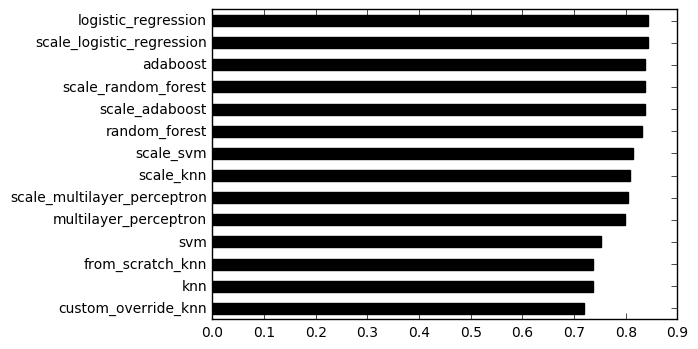

In [44]:
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black')

#### Normal scaling
An additional option is to use the Normalizer() for scaling by setting the scale_type keyword argument to 'normal':

In [213]:
%%time

reload(ppl)

classifiers = ['knn','logistic_regression','svm',
               'multilayer_perceptron','random_forest','adaboost']

prefix = 'normalized'

for estimator in classifiers:
    # Set pipeline keyword arguments
    optimized_pipeline_kwargs = {
        'feature_selection_type': None,
        'scale_type': 'normal',
        'feature_interactions': False,
        'transform_type': None
        }

    # Initialize pipeline
    optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)
    
    # Set pipeline fitting parameters
    fit_kwargs = {
        'cv': 10,
        'num_parameter_combos': None,
        'n_jobs': -1,
        'random_state': 6,
        'suppress_output': False,
        'use_default_param_dist': True,
        'param_dist': None,
        'test_size': 0.2
    }
    
    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)
    
    # Form name used to save optimized pipeline
    pipeline_name = '%s_%s'%(prefix,estimator)
    
    # Save 
    optimized_pipelines[pipeline_name] = optimized_pipeline


Pipeline:

1: scaler           Normalizer                     
                                                   
                    copy                 = 1         
                    norm                 = l2        
                                                   
2: estimator        KNeighborsClassifier           
                                                   
                    n_neighbors          = 6         
                    n_jobs               = 1         
                    algorithm            = auto      
                    metric               = minkowski 
                    metric_params        = None      
                    p                    = 2         
                    weights              = distance  
                    leaf_size            = 30        
                                                   

Training set classification accuracy:	0.763
Test set classification accuracy:	0.803

Confusion matrix:

[[97  9]
 [26 46]]

Normalized 

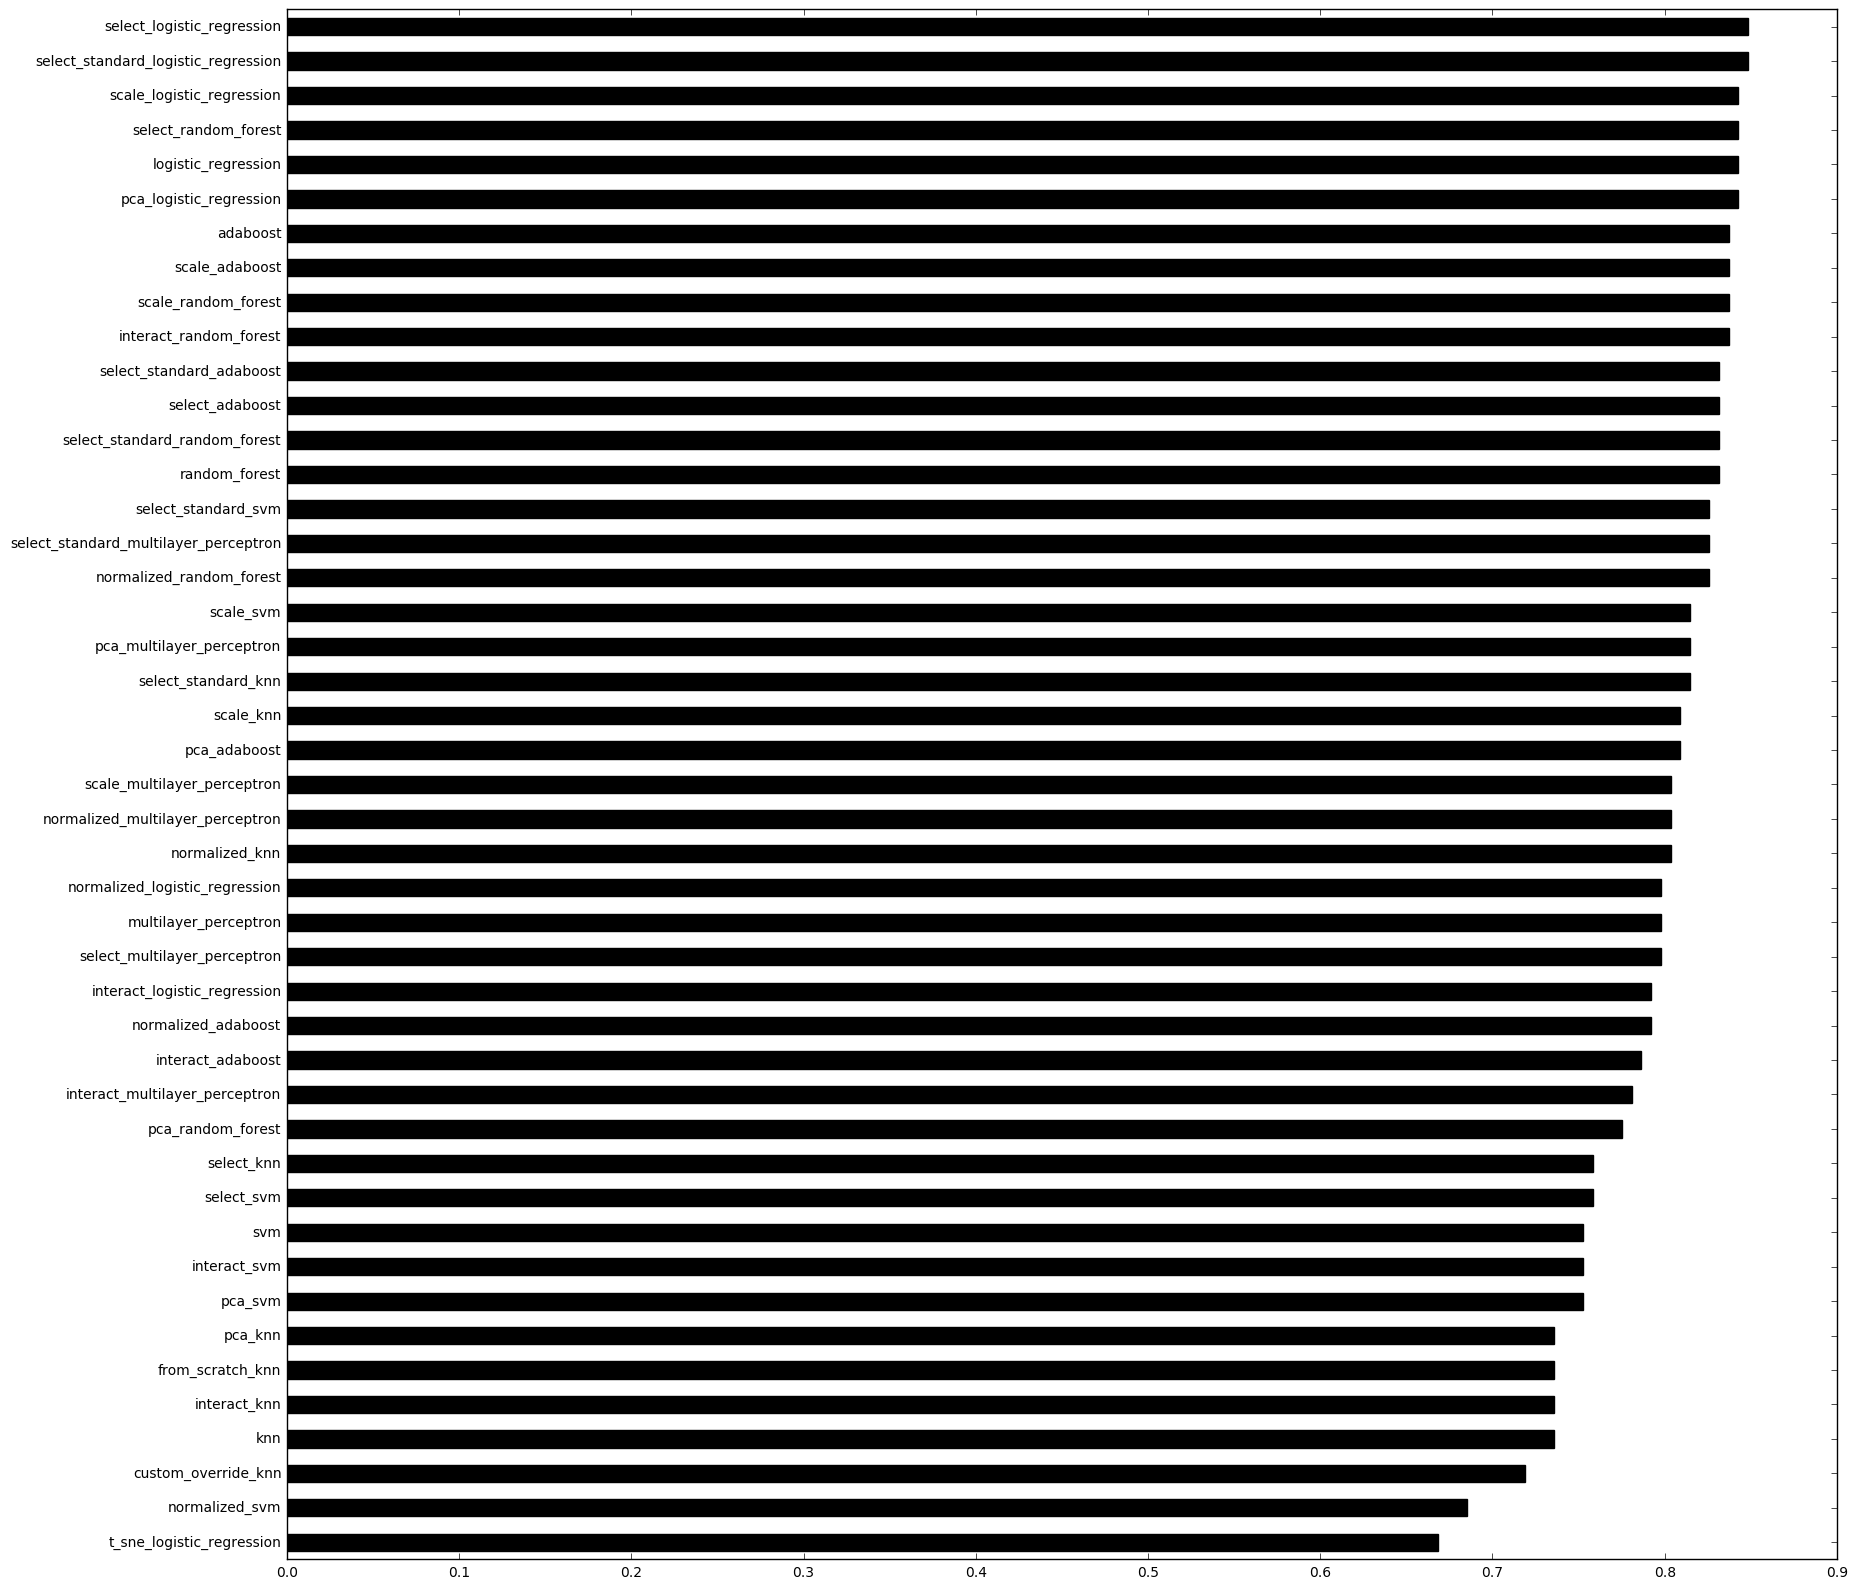

In [216]:
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black',figsize=(20,20))

#### Min-max scaling between 0 and 1
The scale_type keyword argument can be set to 'min_max' to scale the data between 0 and 1:

In [218]:
%%time

reload(ppl)

classifiers = ['knn','logistic_regression','svm',
               'multilayer_perceptron','random_forest','adaboost']

prefix = 'minmax'

for estimator in classifiers:
    # Set pipeline keyword arguments
    optimized_pipeline_kwargs = {
        'feature_selection_type': None,
        'scale_type': 'min_max',
        'feature_interactions': False,
        'transform_type': None
        }

    # Initialize pipeline
    optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)
    
    # Set pipeline fitting parameters
    fit_kwargs = {
        'cv': 10,
        'num_parameter_combos': None,
        'n_jobs': -1,
        'random_state': 6,
        'suppress_output': True,
        'use_default_param_dist': True,
        'param_dist': None,
        'test_size': 0.2
    }
    
    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)
    
    # Form name used to save optimized pipeline
    pipeline_name = '%s_%s'%(prefix,estimator)
    
    # Save 
    optimized_pipelines[pipeline_name] = optimized_pipeline

CPU times: user 7.16 s, sys: 882 ms, total: 8.05 s
Wall time: 55 s


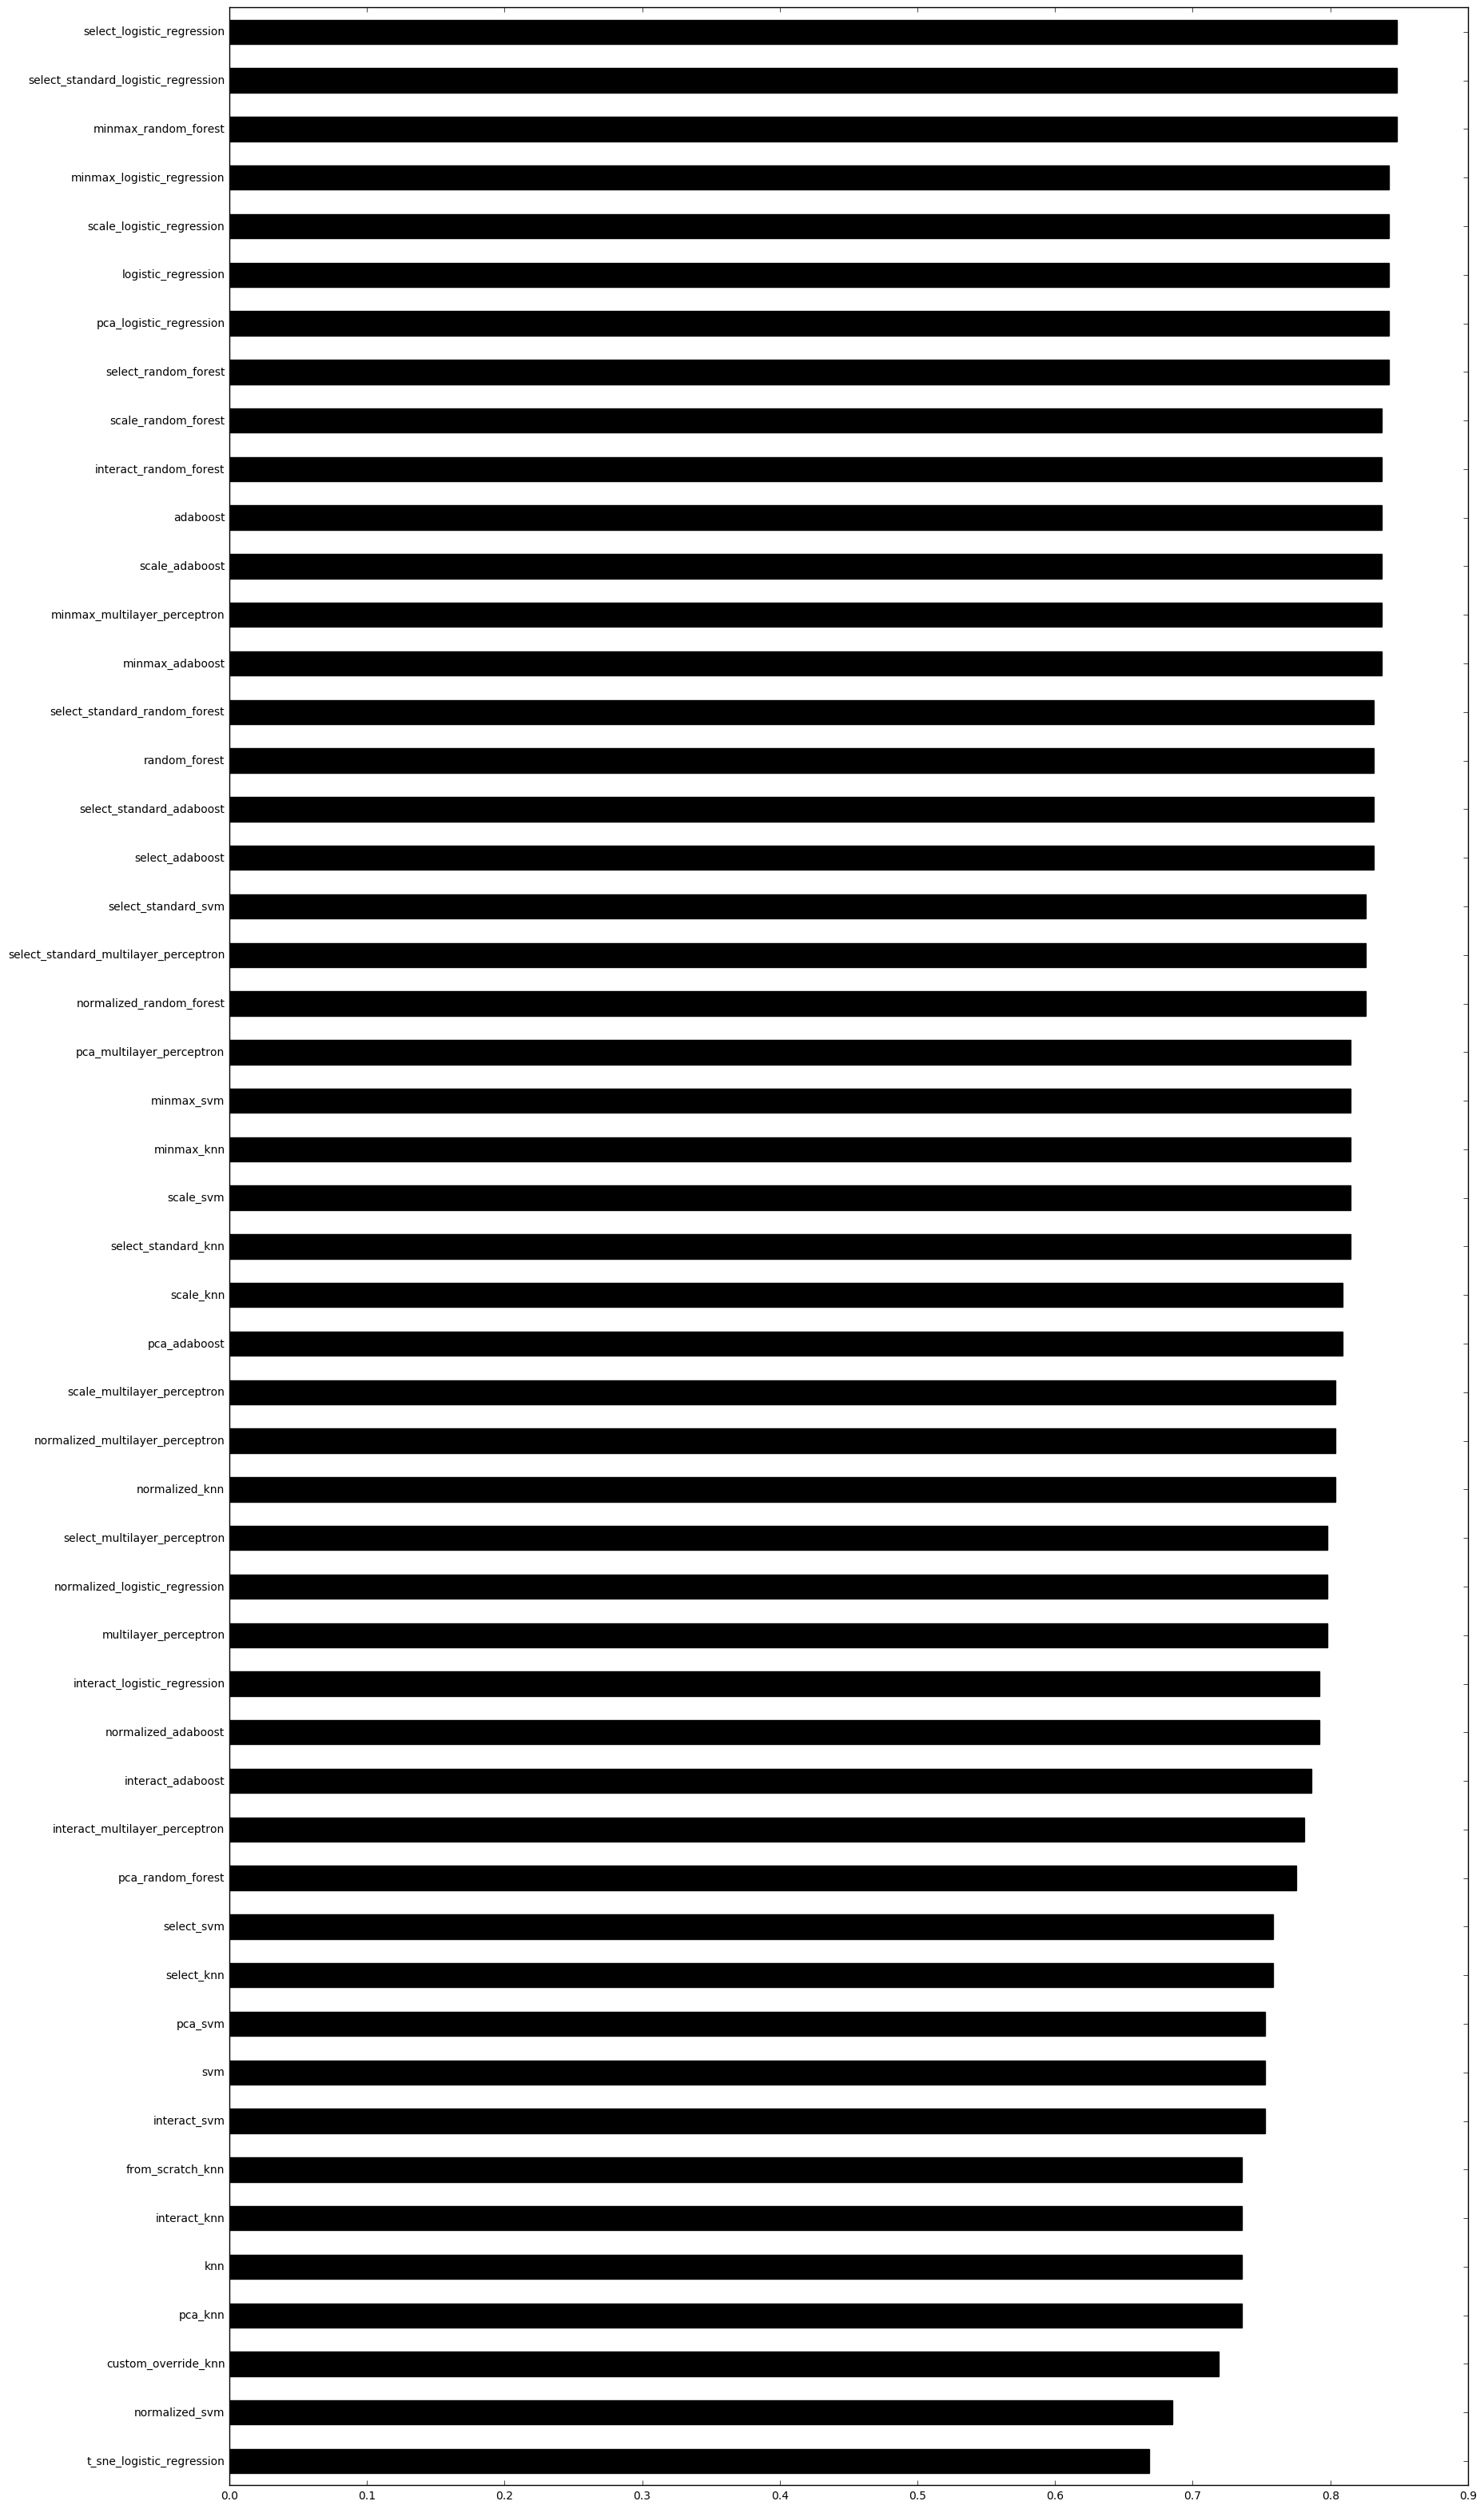

In [220]:
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black',figsize=(20,40))

Logistic regression without scaling still appears to have the best test score. 

### All models with SelectKBest feature selection
Setting the feature_selection_type keyword argument will use SelectKBest with f_classif for feature selection:

In [45]:
%%time

classifiers = ['knn','logistic_regression','svm',
               'multilayer_perceptron','random_forest','adaboost']

prefix = 'select'

for estimator in classifiers:
    # Set pipeline keyword arguments
    optimized_pipeline_kwargs = {
        'feature_selection_type': 'select_k_best',
        'scale_type': None,
        'feature_interactions': False,
        'transform_type': None
        }

    # Initialize pipeline
    optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)
    
    # Set pipeline fitting parameters
    fit_kwargs = {
        'cv': 10,
        'num_parameter_combos': None,
        'n_jobs': -1,
        'random_state': 6,
        'suppress_output': True,
        'use_default_param_dist': True,
        'param_dist': None,
        'test_size': 0.2
    }
    
    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)
    
    # Form name used to save optimized pipeline
    pipeline_name = '%s_%s'%(prefix,estimator)
    
    # Save 
    optimized_pipelines[pipeline_name] = optimized_pipeline

CPU times: user 1min 8s, sys: 4.68 s, total: 1min 13s
Wall time: 7min 13s


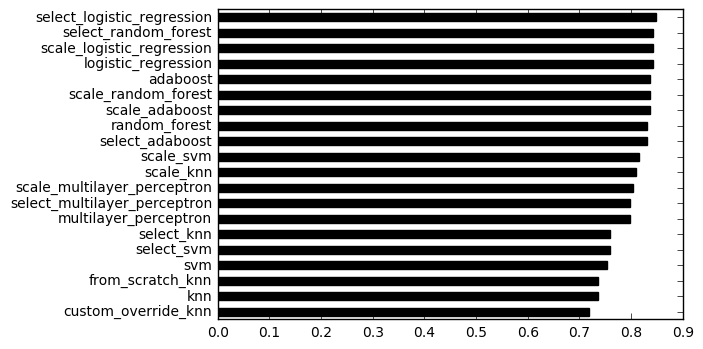

In [46]:
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black')

The addition of selection increased the highest score a bit when coupled with logistic regression.

### All models with feature interaction
Setting the feature_interactions keyword argument to True will cause the use of feature interactions. The default is to only consider pairwise products, though this can be set a to higher number of interactions by setting them in param_dist:

In [52]:
%%time

classifiers = ['knn','logistic_regression','svm',
               'multilayer_perceptron','random_forest','adaboost']

prefix = 'interact'

for estimator in classifiers:
    # Set pipeline keyword arguments
    optimized_pipeline_kwargs = {
        'feature_selection_type': None,
        'scale_type': None,
        'feature_interactions': True,
        'transform_type': None
        }

    # Initialize pipeline
    optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)
    
    # Set pipeline fitting parameters
    fit_kwargs = {
        'cv': 10,
        'num_parameter_combos': None,
        'n_jobs': -1,
        'random_state': 6,
        'suppress_output': True,
        'use_default_param_dist': True,
        'param_dist': None,
        'test_size': 0.2
    }
    
    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)
    
    # Form name used to save optimized pipeline
    pipeline_name = '%s_%s'%(prefix,estimator)
    
    # Save 
    optimized_pipelines[pipeline_name] = optimized_pipeline

CPU times: user 12.1 s, sys: 843 ms, total: 12.9 s
Wall time: 1min 8s


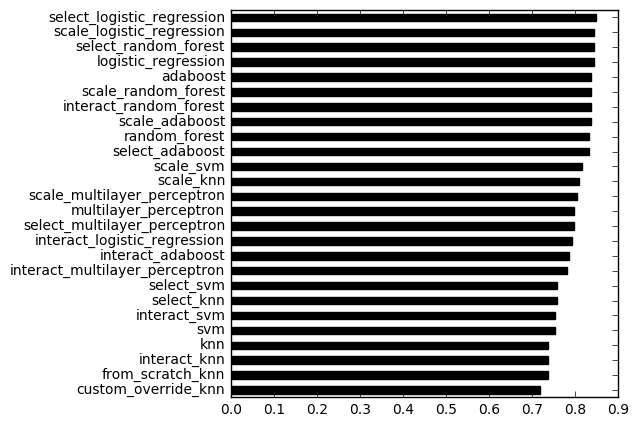

In [54]:
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black',figsize=(5,5))

This doesn't appear to result in many gains in this case.

### All models with transformed data
Setting the transform_type to 'pca' or 't-sne' will apply Principal Component Analysis or t-distributed stochastic neighbor embedding, respectively, to the data before applying the estimator:

In [55]:
%%time

classifiers = ['knn','logistic_regression','svm',
               'multilayer_perceptron','random_forest','adaboost']

prefix = 'pca'

for estimator in classifiers:
    # Set pipeline keyword arguments
    optimized_pipeline_kwargs = {
        'feature_selection_type': None,
        'scale_type': None,
        'feature_interactions': None,
        'transform_type': 'pca'
        }

    # Initialize pipeline
    optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)
    
    # Set pipeline fitting parameters
    fit_kwargs = {
        'cv': 10,
        'num_parameter_combos': None,
        'n_jobs': -1,
        'random_state': 6,
        'suppress_output': True,
        'use_default_param_dist': True,
        'param_dist': None,
        'test_size': 0.2
    }
    
    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)
    
    # Form name used to save optimized pipeline
    pipeline_name = '%s_%s'%(prefix,estimator)
    
    # Save 
    optimized_pipelines[pipeline_name] = optimized_pipeline

CPU times: user 8.06 s, sys: 878 ms, total: 8.94 s
Wall time: 35.1 s


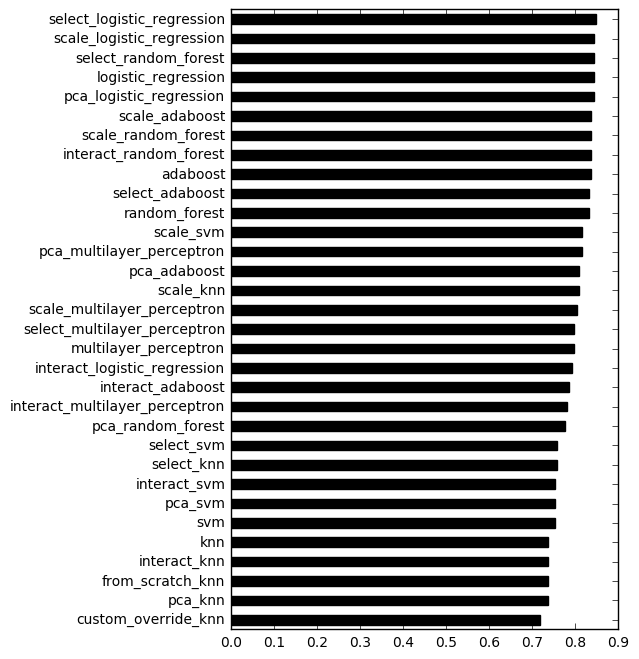

In [57]:
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',
                                                                   color='black',
                                                                   figsize=(5,8))

Here's the use of t-SNE just with logistic regression with only one parameter combination (via setting the num_parameter_combos to 1), since the t-SNE algorithm takes so long:

In [58]:
%%time

classifiers = ['logistic_regression']

prefix = 't_sne'

for estimator in classifiers:
    # Set pipeline keyword arguments
    optimized_pipeline_kwargs = {
        'feature_selection_type': None,
        'scale_type': None,
        'feature_interactions': None,
        'transform_type': 't-sne'
        }

    # Initialize pipeline
    optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)
    
    # Set pipeline fitting parameters
    fit_kwargs = {
        'cv': 10,
        'num_parameter_combos': 1,
        'n_jobs': -1,
        'random_state': 6,
        'suppress_output': True,
        'use_default_param_dist': True,
        'param_dist': None,
        'test_size': 0.2
    }
    
    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)
    
    # Form name used to save optimized pipeline
    pipeline_name = '%s_%s'%(prefix,estimator)
    
    # Save 
    optimized_pipelines[pipeline_name] = optimized_pipeline

CPU times: user 21.3 s, sys: 1.25 s, total: 22.5 s
Wall time: 47.9 s


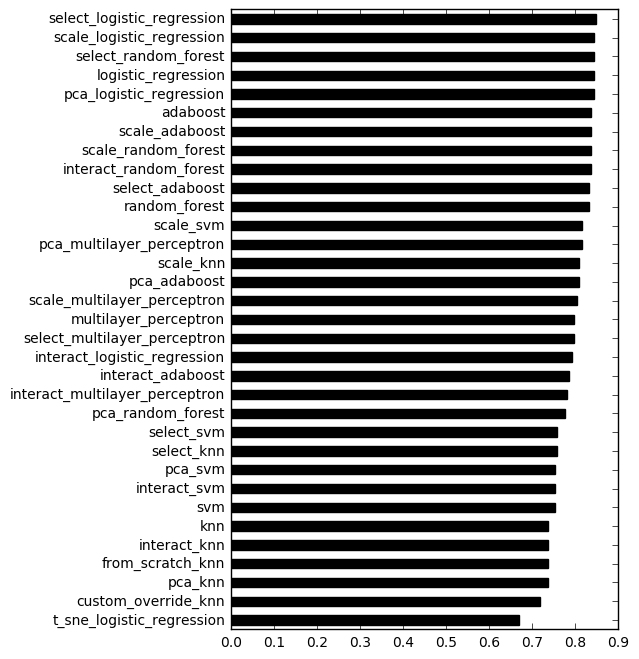

In [59]:
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',
                                                                   color='black',
                                                                   figsize=(5,8))

Use of t-SNE resulted in the lowest score when coupled with logisitic regression.

Applying t-SNE to the data and then testing the 6 classifiers takes about 7 min. This could be optimized by pre-transforming the data once and then applying the classifiers. 

I'm thinking a future update might involve creating a container class to optimize this in the future.

### SelectKBest, standard scaling, and all classifiers
Finally, here we appply feature selection and standard scaling for all 6 classifiers:

In [60]:
%%time

classifiers = ['knn','logistic_regression','svm',
               'multilayer_perceptron','random_forest','adaboost']

prefix = 'select_standard'

for estimator in classifiers:
    # Set pipeline keyword arguments
    optimized_pipeline_kwargs = {
        'feature_selection_type': 'select_k_best',
        'scale_type': 'standard',
        'feature_interactions': None,
        'transform_type': None
        }

    # Initialize pipeline
    optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)
    
    # Set pipeline fitting parameters
    fit_kwargs = {
        'cv': 10,
        'num_parameter_combos': None,
        'n_jobs': -1,
        'random_state': 6,
        'suppress_output': True,
        'use_default_param_dist': True,
        'param_dist': None,
        'test_size': 0.2
    }
    
    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)
    
    # Form name used to save optimized pipeline
    pipeline_name = '%s_%s'%(prefix,estimator)
    
    # Save 
    optimized_pipelines[pipeline_name] = optimized_pipeline

CPU times: user 1min 21s, sys: 6.04 s, total: 1min 27s
Wall time: 7min 25s


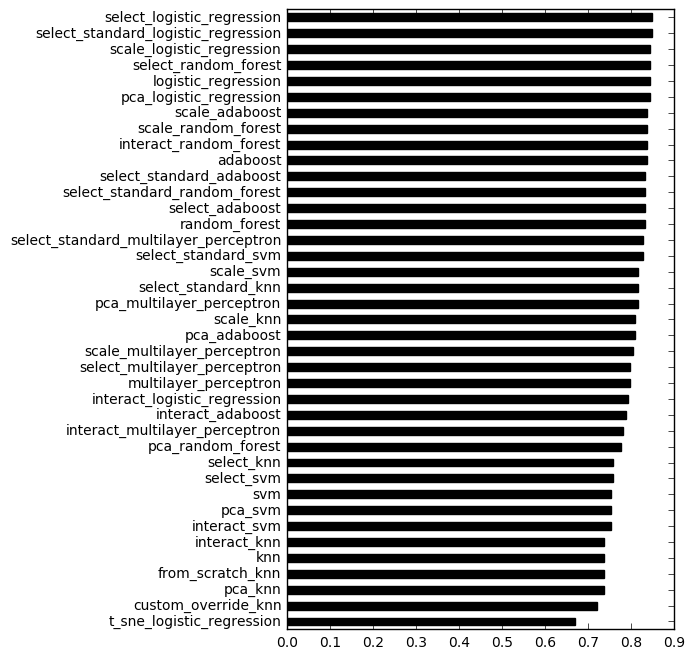

In [61]:
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',
                                                                   color='black',
                                                                   figsize=(5,8))

Out of 39 different pre-processing/transformation/classification combinations the best test score was achieved by logistic regression with data that has been through feature selection using SelectKBest with f_classif.

Let's look at the report for it:

In [66]:
print optimized_pipelines['select_logistic_regression']


Pipeline:

1: feature_selectionSelectKBest                    
                                              
               k                    = 15        
               score_func           = <function f_classif at 0x115628758>
                                              
2: estimator   LogisticRegression             
                                              
               warm_start           = 0         
               C                    = 100000.0  
               n_jobs               = 1         
               verbose              = 0         
               intercept_scaling    = 1         
               fit_intercept        = 1         
               max_iter             = 100       
               penalty              = l2        
               multi_class          = ovr       
               random_state         = None      
               dual                 = 0         
               tol                  = 0.0001    
               solver               =

Our best model has a test accuracy of 84.8%, which is much better than the 62% value for the null model (always predict didn't survive). 

Turns out that 15 of the features were selected. 

The optimized pipline is stored in the .pipeline field of the OptimizedPipeline instance and can be used normally.

Let's figure out what features were selected by SelectKBest and access the model coefficients for model interpretability:

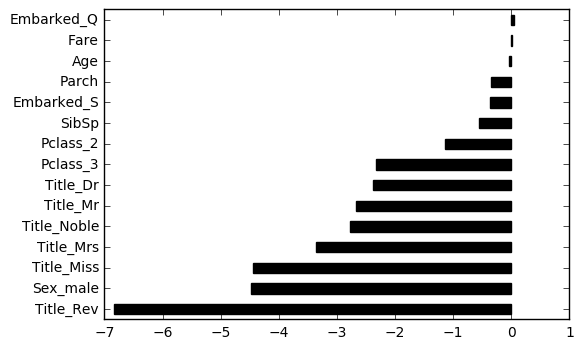

In [187]:
import numpy as np

optimized_pipeline_steps = optimized_pipelines['select_logistic_regression'].pipeline.steps

select_k_best_mask = optimized_pipeline_steps[0][1].get_support()

selected_features = list(np.array(input_features)[select_k_best_mask])

model_coefs = optimized_pipeline_steps[-1][1].coef_

coef_df = pd.Series(model_coefs[0],index=selected_features)

coef_df.sort_values().plot(kind='barh',color='black')

Looks like SelectKBest merely removed the Military Title flag.

Being a reverend and then a male seems to have the greatest effect on the log odds.

### Predicting survival with the optimal model
All one has to do to make a prediction is use the .predict method of the pipeline in the .pipeline field.

Here's an example of predicting whether I would survive on the Titanic. I'm 32, would probably have one family member with me, might be Pclass1 (I'd hope), male, have a Ph.D (if that's what they mean by Dr.). I'm using the median Fare for Pclass 1 and randomly chose a city to have embarked from:

In [208]:
personal_stats = [32,1,0,df[df['Pclass']==1]['Fare'].median(),0,0,1,1,0,1,0,0,0,0,0,0]

zip(personal_stats,X.columns)

[(32, 'Age'),
 (1, 'SibSp'),
 (0, 'Parch'),
 (60.287499999999994, 'Fare'),
 (0, 'Pclass_2'),
 (0, 'Pclass_3'),
 (1, 'Sex_male'),
 (1, 'Embarked_Q'),
 (0, 'Embarked_S'),
 (1, 'Title_Dr'),
 (0, 'Title_Military'),
 (0, 'Title_Miss'),
 (0, 'Title_Mr'),
 (0, 'Title_Mrs'),
 (0, 'Title_Noble'),
 (0, 'Title_Rev')]

In [209]:
optimized_pipelines['select_logistic_regression'].pipeline.predict(personal_stats)

/Users/cmshymansky/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([1], dtype=uint8)

I survived!

Lets look at my actual probability of surviving:

In [210]:
optimized_pipelines['select_logistic_regression'].pipeline.predict_proba(personal_stats)

/Users/cmshymansky/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.48386641,  0.51613359]])

I would have a ~52% chance of survival, which seems a bit to low to celebrate.

## Summary
I've shown how to use pyplearnr to try out 39 different pipeline combinations validated with stratified 10-folds cross-validation using a combination of simple keyword arguments with some additional customization options. Also, I've shown how to access the model parameters, predict survival, and check the actual predicted probability according to the optimized pipeline.

Please let me know if you have any questions or suggestions about how to improve this tool, my code, the approach I'm taking, etc.